In [37]:
import numpy as np
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import matplotlib.pyplot as plt
import functools

@functools.lru_cache(100)
def spc(lval):
    mol = pyscf.gto.M(atom='H 0 0 0.; H 0 0 1.', basis='def2-TZVP', verbose=0)
    deltaZ = np.array((1, -1))*lval

    calc = pyscf.scf.RHF(mol)
    calc.conv_tol = 1e-8
    calc.conv_tol_grad = 1e-8

    mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()/(1 / 0.52917721067), deltaZ)  
    class NoSelfQMMM(mf.__class__):
            def energy_nuc(self):
                    return (1+deltaZ[0])*(1+deltaZ[1])/(1/0.52917721067)
    mf = NoSelfQMMM()
    hfe=mf.kernel(direct=False)
    mycc = pyscf.cc.CCSD(mf)
    mycc.conv_tol = 1e-12
    mycc.run()

    dm1 = mycc.make_rdm1()
    dm1_ao = np.einsum('pi,ij,qj->pq', mf.mo_coeff, dm1, mf.mo_coeff.conj())
    epns = []
    for site in (0, 1):
        mol.set_rinv_orig_(mol.atom_coords()[site])
        epns.append(np.matmul( dm1_ao,mol.intor('int1e_rinv')).trace())
    return epns
spc(0)

[1.584873122119257, 1.5848731221192571]

In [2]:
def dE(lval):
    es = spc(lval)
    return es[0]-es[1]

In [3]:
import findiff

In [4]:
def get_fd_coefficients(order, delta):
    if order == 0:
        return [0], [1]
    cs = findiff.coefficients(deriv=order, acc=order)['center']
    return cs['offsets']*delta, cs['coefficients']/(delta**order)

In [5]:
def get_order(order, delta):
    E = 0.
    for lval, weight in zip(*get_fd_coefficients(order, delta)):
        E += dE(lval) * weight
    return -E

In [8]:
get_order(1, 0.04)

-2.566151374791445

In [65]:
#results = []
dlvals = 10**np.linspace(-20, 1,100)
for order in (4, 5, 6):
    res = [get_order(order, _) - get_order(order, 0.05) for _ in dlvals]
    results.append(res)

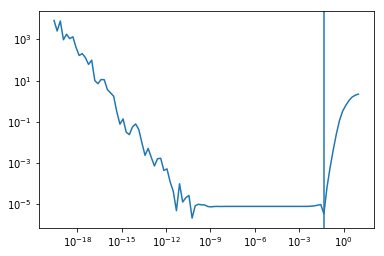

In [46]:
plt.loglog(dlvals[2:], np.abs(np.array(res[2:])))
plt.axvline(0.05)

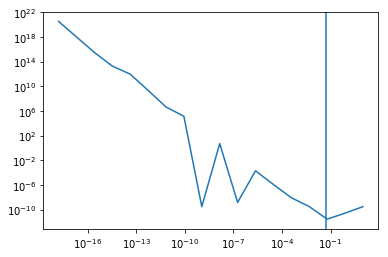

In [41]:
plt.loglog(dlvals[2:], np.abs(np.array(res[2:])))
plt.axvline(0.05)
# higher orders

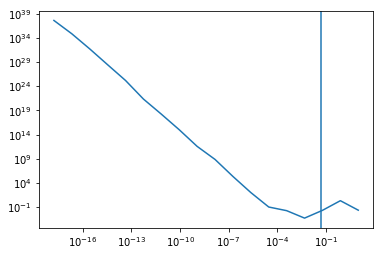

In [43]:
plt.loglog(dlvals[2:], np.abs(np.array(res[2:])))
plt.axvline(0.05)
# higher orders

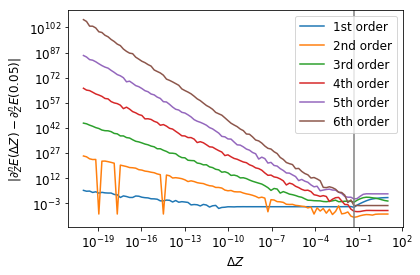

In [66]:
plt.rcParams['font.size'] = 12
plt.loglog(dlvals, np.abs(results[0]), label='1st order')
plt.loglog(dlvals, np.abs(results[1]), label='2nd order')
plt.loglog(dlvals, np.abs(results[2]), label='3rd order')
plt.loglog(dlvals, np.abs(results[3]), label='4th order')
plt.loglog(dlvals, np.abs(results[4]), label='5th order')
plt.loglog(dlvals, np.abs(results[5]), label='6th order')
plt.axvline(0.05, color='grey')
plt.legend()
plt.xlabel(r'$\Delta Z$')
plt.ylabel(r'$|\partial^n_ZE(\Delta Z) - \partial^n_ZE(0.05)|$')
plt.savefig('FDSensitivity.pdf', bbox_inches='tight')